In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/the-movies-dataset/ratings.csv
/kaggle/input/the-movies-dataset/links_small.csv
/kaggle/input/the-movies-dataset/credits.csv
/kaggle/input/the-movies-dataset/keywords.csv
/kaggle/input/the-movies-dataset/movies_metadata.csv
/kaggle/input/the-movies-dataset/ratings_small.csv
/kaggle/input/the-movies-dataset/links.csv
/kaggle/input/w2v-model/word2vec_trainingdata_all_size25.model
/kaggle/input/bert-movie/__results__.html
/kaggle/input/bert-movie/senvec_bert.npy
/kaggle/input/bert-movie/__notebook__.ipynb
/kaggle/input/bert-movie/__output__.json
/kaggle/input/bert-movie/custom.css


In [2]:
#import packages for later use
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

from keras.preprocessing.text import text_to_word_sequence
from gensim.models import word2vec,TfidfModel
from gensim.corpora import Dictionary
import gensim.downloader as api
dataset = api.load("text8")

from scipy.spatial import distance
from sklearn.metrics.pairwise import cosine_similarity

In [3]:
#input dataset
X = pd.read_csv("../input/the-movies-dataset/movies_metadata.csv")
overview = X['overview']
name_overview = X[['original_title','overview','id']]

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3166: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
#show some overviews (dataset)
overview.head()

0    Led by Woody, Andy's toys live happily in his ...
1    When siblings Judy and Peter discover an encha...
2    A family wedding reignites the ancient feud be...
3    Cheated on, mistreated and stepped on, the wom...
4    Just when George Banks has recovered from his ...
Name: overview, dtype: object

In [5]:
print('The size of training sample that we use for trianing is {}'.format(overview.shape[0]))

The size of training sample that we use for trianing is 45466


In [6]:
#prepare for the corpus
sentence=[]
for i in overview:
    sentence.append(text_to_word_sequence(str(i),filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~\t\n',lower=True,split=" "))

In [7]:
# this process is slow
# w2v = word2vec.Word2Vec(sentence,vector_size=25,window=25,min_count=1,workers=5,sg=1,hs=1,sorted_vocab=1,seed=42)
# w2v.save("word2vec_trainingdata_all_size25.model")

In [8]:
#use the weight we pretrained
w2v = word2vec.Word2Vec.load("../input/w2v-model/word2vec_trainingdata_all_size25.model")

In [9]:
#see the results of w2v
w2v.wv.most_similar('murder', topn=10)

[('murderer', 0.9479272961616516),
 ('accused', 0.9181045293807983),
 ('murdered', 0.9108615517616272),
 ('witnesses', 0.903934121131897),
 ('clammed', 0.9032635688781738),
 ('suspected', 0.9014613032341003),
 ('case', 0.9005158543586731),
 ('smugly', 0.8988717794418335),
 ('kostenko', 0.8976795673370361),
 ('pled', 0.8955886363983154)]

In [10]:
w2v.wv.most_similar('woman', topn=10)

[('young', 0.9197728633880615),
 ('beautiful', 0.9060701131820679),
 ('meets', 0.8998078107833862),
 ("'samapti'", 0.8989660143852234),
 ('finds', 0.8981448411941528),
 ('falls', 0.8972214460372925),
 ('girl', 0.8947992920875549),
 ('mentaly', 0.8886485695838928),
 ('elena…', 0.8881946802139282),
 ('fida', 0.8878426551818848)]

In [11]:
#construct a DataFrame of the word vectors for PCA
df=pd.DataFrame(w2v.wv.vectors,index = w2v.wv.index_to_key)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
the,-0.554620,-0.489051,0.360068,0.054079,0.315755,0.235811,0.168385,0.117909,0.382723,0.410456,...,0.261216,0.194322,0.281648,-0.463229,0.281549,-0.536137,-0.046369,-0.452382,-0.386439,0.401082
a,-0.495149,-0.467366,0.396854,0.029068,0.276234,0.179398,0.274193,0.253885,0.537207,0.255748,...,0.412243,0.139976,0.099970,-0.370480,0.109964,-0.359061,-0.008121,-0.276642,-0.486201,0.388498
and,-0.614852,-0.452978,0.361240,0.133848,0.330014,0.142626,0.133154,0.103189,0.452030,0.155445,...,0.278862,0.197140,0.275914,-0.362461,0.156512,-0.441347,-0.160301,-0.309662,-0.327736,0.416853
to,-0.352416,-0.506248,0.484138,0.103401,0.335105,0.375433,0.101924,0.129506,0.557162,0.254125,...,0.253672,0.186020,0.205006,-0.184125,0.236829,-0.551447,-0.202993,-0.396824,-0.388061,0.465211
of,-0.727051,-0.372660,0.313623,0.111965,0.328205,0.099556,0.117312,0.087938,0.395128,0.316632,...,0.214842,0.217246,0.264825,-0.523333,0.257746,-0.588561,-0.090255,-0.314000,-0.401444,0.421480


In [12]:
#correlation matrix of word vectors
X_corr=df.corr()

#get eigen values and eigen vectors
values,vectors=np.linalg.eig(X_corr)

#sort the eigen vectors and their corresponding eigen values in descending order
args = (-values).argsort()
values = vectors[args]
vectors = vectors[:, args]

#take first 2 components
new_vectors=vectors[:,:2]

#project word vectors onto 2d space
neww_X=np.dot(w2v.wv.vectors,new_vectors)

Text(0.5, 1.0, 'Word Embedding Space')

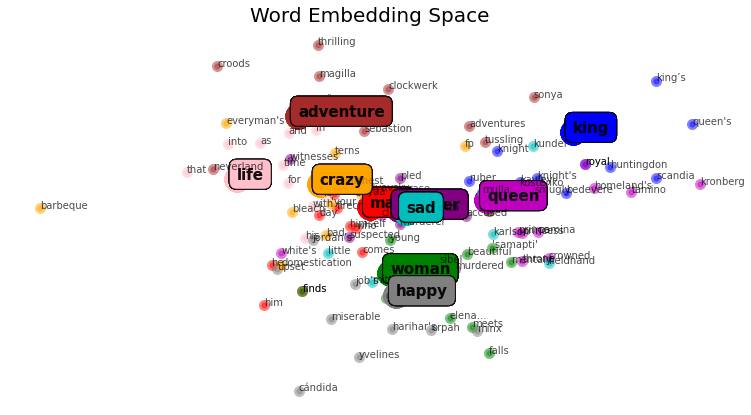

In [13]:
#plot word embedding space projected onto 2D space

plt.figure(figsize=(13,7))

vocab= w2v.wv.index_to_key
np.random.seed(42)

# get fixed words

words = ['man','woman','king','queen','murder','life','sad','happy','adventure','crazy']

# get random words (comment out the part above and use the part below)

# num = 8
# rnd = np.random.randint(0,neww_X.shape[0],num)
# words = [vocab[i] for i in rnd]

#colors
colors = ['red','green','blue','m','purple','pink','c','grey','brown','orange']

for i,word in enumerate(words):
    idxs = [w2v.wv.get_index(i[0]) for i in w2v.wv.most_similar(word, topn=10)]
    idxs.append(w2v.wv.get_index(word))
    color = colors[i%10]
    
    for idx in idxs[:-1]:
        plt.scatter(neww_X[idx,0],neww_X[idx,1],color=color,linewidths=5,alpha=0.5)
        
        plt.annotate(vocab[idx],xy=(neww_X[idx,0],neww_X[idx,1]),alpha=0.7)
        
        plt.scatter(neww_X[idxs[-1],0],neww_X[idxs[-1],1],color=color,linewidths=20)
        
        plt.annotate(vocab[idxs[-1]],xy=(neww_X[idxs[-1],0],neww_X[idxs[-1],1]),
                    weight='heavy',bbox=dict(boxstyle='round,pad=0.5', 
                    fc=color, ec='k', lw=1,alpha=0.7), fontsize=15,alpha=0.9)
   

plt.axis('off')
plt.title("Word Embedding Space",size=20)

In [14]:
# Sentence embedding using average word embeddings
def sen2vec_avg(sentence):
    res = []
    for i in range(len(sentence)):
        vec = np.zeros(25)
        for j in sentence[i]:
            vec += w2v.wv[j]
        vec = vec/len(sentence[i])
        res.append(vec)   
    return res
senvec_w2v = np.array(sen2vec_avg(sentence))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


In [15]:
# Sentence embedding using TF-IDF weighted average word embeddings
def sen2vec_wavg(sentence,dataset):
    dct = Dictionary(dataset)
    dataset = api.load("text8")
    dct = Dictionary(dataset)  # fit dictionary
    corpus = [dct.doc2bow(line) for line in sentence] 
    model = TfidfModel(corpus)
    res = []
    for i in range(len(sentence)):
        tfidf = model[corpus[i]]
        vector = np.zeros(25)
        for v in tfidf:
            vector += w2v.wv[dct[v[0]]]*v[1]
        res.append(vector)
    return res
senvec_w2vw = np.array(sen2vec_wavg(sentence,dataset))

In [16]:
#check the shape of the result
senvec_w2v.shape

(45466, 25)

In [17]:
#get similar movies
def similarity_movie(name,top,name_overview,senvec,text_out=True,show_sim=True,return_idx=False):
    index = name_overview.loc[name_overview['original_title'] == name].index[0]
    ans = np.zeros(len(senvec))
    ans += 1000
    senvec = np.nan_to_num(senvec)
    for i in range(len(senvec)):
        if(np.isfinite(senvec[i]).all()):
            ans[i] = distance.euclidean(senvec[index],senvec[i])
            
    #give the loc of top n items with least euclidean distances
    idx = np.argsort(ans)[1:top+1]
    
    #get cosine similarity
    sim = cosine_similarity(senvec[index].reshape(1,-1),senvec[idx])
    
    #print out the results
    if text_out==True:
        for k,i in enumerate(idx):
            print('Title: ',name_overview['original_title'].iloc[i])
            if show_sim==True:
                print('Similarity: %.1f%%'%(100*sim[0][k]))
            print('Overview: ',name_overview['overview'].iloc[i])
            print('\n')
            
    if return_idx==True :
        return idx

In [18]:
#check the output index
similarity_movie('Batman',10,name_overview,senvec_w2v,text_out=False,return_idx=True)

array([12481, 15511, 18252, 23172,  1328, 39347,  9230, 32267, 42168,
       25670])

In [19]:
#plot movie (sentence) embedding space
def plot_movie_embed(res,vocab=name_overview ['original_title'],use_random = False,seed=42):
    
    #use methods above to do PCA
    df = pd.DataFrame(res,vocab)
    X_corr=df.corr()
    values,vectors=np.linalg.eig(X_corr)
    args = (-values).argsort()
    values = vectors[args]
    vectors = vectors[:, args]
    new_vectors=vectors[:,:2]
    neww_X=np.dot(np.array(res),new_vectors)
    
    plt.figure(figsize=(13,7))
    
    
    #plot movies 
    num = 5
    
    #use given movies
    if use_random == False:

        names = ['Batman','Toy Story','Avatar','2012','Pulp Fiction']
        movies = [name_overview.loc[name_overview['original_title'] == i].index[0] for i in names]

    # get random movies
    else: 
        np.random.seed(seed)
        
        rnd = np.random.randint(0,neww_X.shape[0],num)
        movies = rnd
        movie_name = [name_overview ['original_title'].iloc[0] for i in rnd]

    colors = ['red','green','blue','m','purple','pink']

    for i,word in enumerate(movies):

        #similar movies

        idxs = similarity_movie(name_overview ['original_title'].iloc[movies[i]],10,name_overview,res,text_out=False,return_idx=True).tolist()

        #movie itself

        idxs.append(movies[i])

        color = colors[i]

        for idx in idxs[:-1]:
            plt.scatter(neww_X[idx,0],neww_X[idx,1],color=color,linewidths=5,alpha=0.5)
            plt.annotate(vocab[idx],xy=(neww_X[idx,0],neww_X[idx,1]),alpha=0.7)
        plt.scatter(neww_X[idxs[-1],0],neww_X[idxs[-1],1],color=color,linewidths=20)
        plt.annotate(vocab[idxs[-1]],xy=(neww_X[idxs[-1],0],neww_X[idxs[-1],1]),weight='heavy',bbox=dict(boxstyle='round,pad=0.5', fc=color, ec='k', lw=1,alpha=0.7), fontsize=15)
   
    plt.axis('off')
    
    plt.title("Movie Embedding Space",size=20)

In [20]:
#get top 10 similar movies of Batman using average word embedding method
similarity_movie('Batman',10,name_overview,senvec_w2v)

Title:  The Dark Knight
Similarity: 99.3%
Overview:  Batman raises the stakes in his war on crime. With the help of Lt. Jim Gordon and District Attorney Harvey Dent, Batman sets out to dismantle the remaining criminal organizations that plague the streets. The partnership proves to be effective, but they soon find themselves prey to a reign of chaos unleashed by a rising criminal mastermind known to the terrified citizens of Gotham as the Joker.


Title:  Batman: Under the Red Hood
Similarity: 98.9%
Overview:  Batman faces his ultimate challenge as the mysterious Red Hood takes Gotham City by firestorm. One part vigilante, one part criminal kingpin, Red Hood begins cleaning up Gotham with the efficiency of Batman, but without following the same ethical code.


Title:  The Dark Knight Rises
Similarity: 98.7%
Overview:  Following the death of District Attorney Harvey Dent, Batman assumes responsibility for Dent's crimes to protect the late attorney's reputation and is subsequently hunted

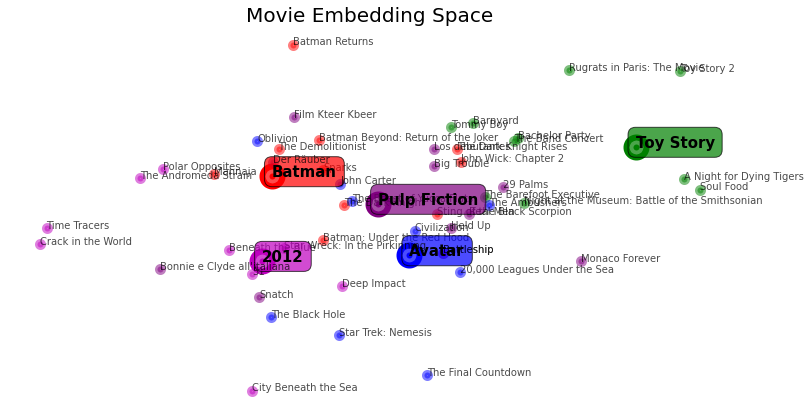

In [21]:
#plot movie (sentence) embedding space by average word vectors, using given movies
plot_movie_embed(senvec_w2v,vocab=name_overview ['original_title'],use_random = False,seed=42)

/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 48148 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 46988 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 45212 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 44032 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 51313 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 21610 missing from current font.
  font.set_

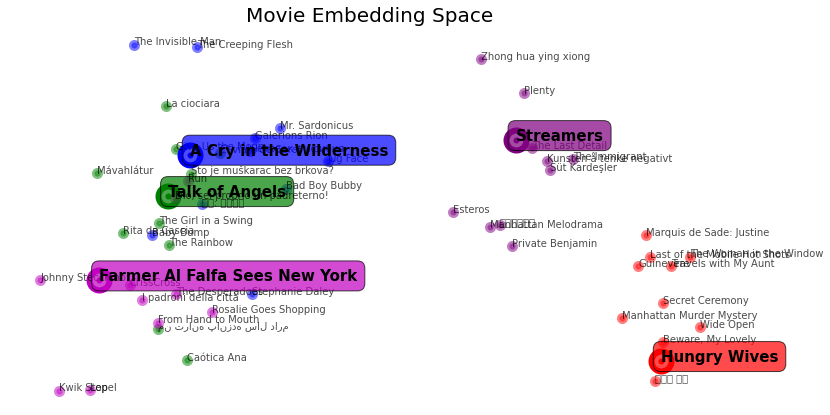

In [22]:
#plot movie (sentence) embedding space by average word vectors, using random movies (change the seed to see other results)
plot_movie_embed(senvec_w2vw,vocab=name_overview ['original_title'],use_random = True,seed=42)

In [23]:
#get top 10 similar movies of Batman using TF-IDF weighted average word embedding method
similarity_movie('Batman',10,name_overview,senvec_w2vw)

Title:  Batman: The Dark Knight Returns, Part 2
Similarity: 97.0%
Overview:  Batman has stopped the reign of terror that The Mutants had cast upon his city.  Now an old foe wants a reunion and the government wants The Man of Steel to put a stop to Batman.


Title:  Batman: Under the Red Hood
Similarity: 97.1%
Overview:  Batman faces his ultimate challenge as the mysterious Red Hood takes Gotham City by firestorm. One part vigilante, one part criminal kingpin, Red Hood begins cleaning up Gotham with the efficiency of Batman, but without following the same ethical code.


Title:  Sparks
Similarity: 95.8%
Overview:  A masked vigilante who discovers the dark side to heroism. Going after the nation's most notorious super criminal leaves Sparks' life and reputation in ruins.


Title:  DC Showcase: Catwoman
Similarity: 95.0%
Overview:  Catwoman attempts to track down a mysterious cargo shipment that is linked to a Gotham City crime boss called Rough Cut.


Title:  The Demolitionist
Similarity

/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 48148 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 46988 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 45212 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 44032 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 51313 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 21610 missing from current font.
  font.set_

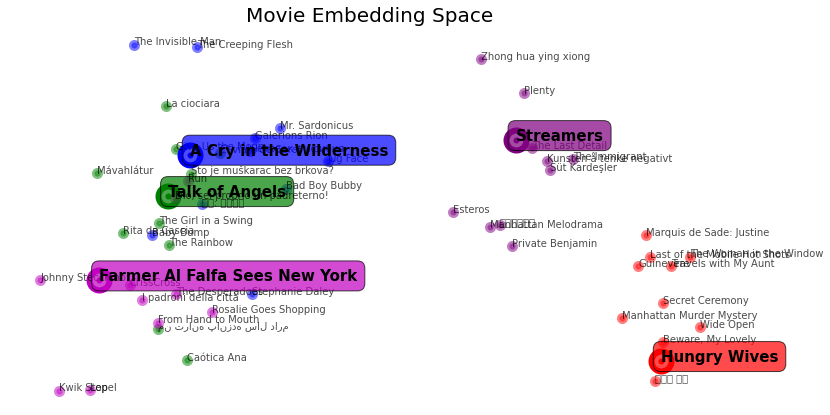

In [24]:
#plot movie (sentence) embedding space by TF-IDF weighted average word vectors, using given movies
plot_movie_embed(senvec_w2vw,vocab=name_overview ['original_title'],use_random = False,seed=42)

/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 48148 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 46988 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 45212 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 44032 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 51313 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 21610 missing from current font.
  font.set_

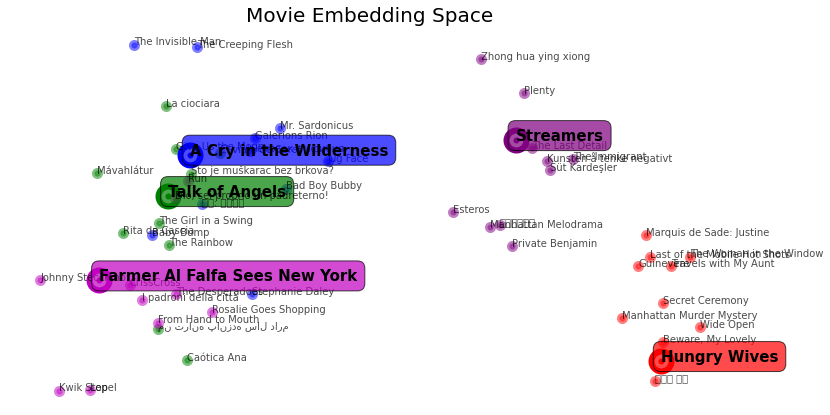

In [25]:
#plot movie (sentence) embedding space by TF-IDF weighted average word vectors,  using random movies (change the seed to see other results)
plot_movie_embed(senvec_w2vw,vocab=name_overview ['original_title'],use_random = True,seed=42)

In [26]:
#get our pretrained BERT sentence embeddings (It will take more than 3hrs to get these embeddings)
senvec_bert = np.load('../input/bert-movie/senvec_bert.npy')

In [27]:
#check the shape of the sentence vectors
senvec_bert.shape

(45466, 1, 768)

In [28]:
#reshape to make it compatible to the functions we define
senvec_bert = senvec_bert.reshape(45466,768)

In [29]:
#get top 10 similar moview of Batman using BERT sentence embedding
similarity_movie('Batman',10,name_overview,senvec_bert)

Title:  The Dark Knight
Similarity: 90.7%
Overview:  Batman raises the stakes in his war on crime. With the help of Lt. Jim Gordon and District Attorney Harvey Dent, Batman sets out to dismantle the remaining criminal organizations that plague the streets. The partnership proves to be effective, but they soon find themselves prey to a reign of chaos unleashed by a rising criminal mastermind known to the terrified citizens of Gotham as the Joker.


Title:  Batman Beyond: Return of the Joker
Similarity: 90.7%
Overview:  The Joker is back with a vengeance, and Gotham's newest Dark Knight needs answers as he stands alone to face Gotham's most infamous Clown Prince of Crime.


Title:  Batman: The Killing Joke
Similarity: 89.7%
Overview:  As Batman hunts for the escaped Joker, the Clown Prince of Crime attacks the Gordon family to prove a diabolical point mirroring his own fall into madness. Based on the graphic novel by Alan Moore and Brian Bolland.


Title:  Hell Up In Harlem
Similarity: 8

/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 33865 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 21839 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 12489 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 12521 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 12360 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 12418 missing from current font.
  font.set_

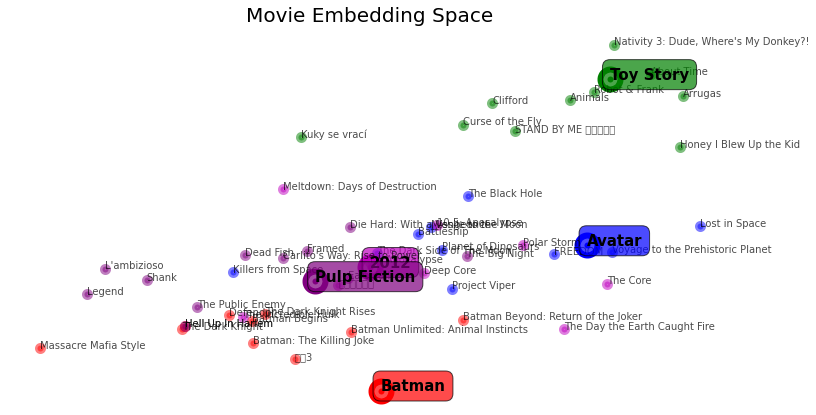

In [30]:
#plot movie (sentence) embedding space by BERT sentence vectors, using given movies
plot_movie_embed(senvec_bert,vocab=name_overview ['original_title'],use_random = False,seed=42)

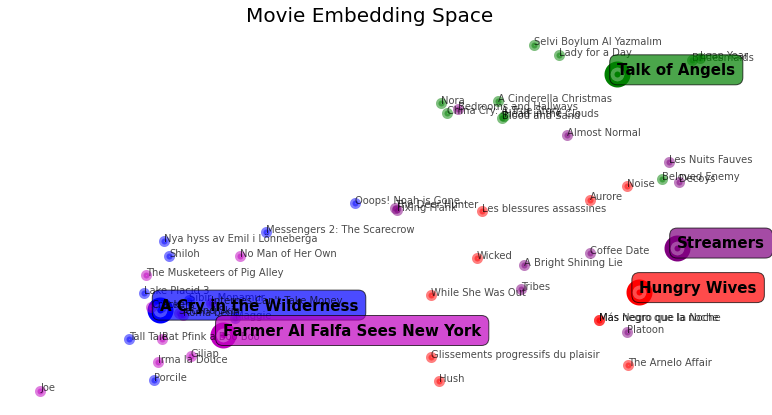

In [31]:
#plot movie (sentence) embedding space by BERT sentence vectors, using random movies (change the seed to see other results)
plot_movie_embed(senvec_bert,vocab=name_overview ['original_title'],use_random = True,seed=42)